# GPN-CUP

## Пример прогнозной модели

В данном файле будет построен пример прогнозной модели `SARIMAX` с использованием пуассоновской регрессии.

Импортируем библиотеки и данные

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.rcParams['figure.figsize'] = (10, 6)

In [3]:
forecast_data = pd.read_parquet('forecast_data.parquet')
forecast_data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x39,x40,x41,x42,x43,x44,date,shop_id,goods_type,y
0,4.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2146-01-01,0,Съедобный хлам,6.0
1,4.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2146-01-01,0,Хлам,26.0
2,4.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2146-01-01,0,Бензак,10537.0
3,5.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2146-01-01,1,Съедобный хлам,17.0
4,5.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2146-01-01,1,Хлам,9.0


In [4]:
clustering = pd.read_csv('clustering.tsv', index_col=0)
clustering.head()

,shop_id,Кластеризация по факторам (30),Кластеризация по факторам (55),Кластеризация по факторам (350),Кластеризация по рядам динамики (Съедобный хлам),Кластеризация по рядам динамики (Хлам),Кластеризация по рядам динамики (Бензак),Кластеризация по рядам динамики (Броня и одежда),Кластеризация по рядам динамики (Солярка),Кластеризация по рядам динамики (Ядер-Кола),Кластеризация по рядам динамики (Патроны),Кластеризация по рядам динамики (Модификации тачки),Кластеризация по рядам динамики (Оружие),Кластеризация по рядам динамики (Жидкости для тачки),Кластеризация по рядам динамики (Медпрепараты и еда)
0,0,0,11,120,2.0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN
1,1,0,11,120,2.0,0.0,0,0.0,2.0,NaN,NaN,NaN,NaN,2.0,NaN
2,2,23,2,349,2.0,0.0,0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,2.0
3,3,0,10,348,2.0,0.0,0,0.0,2.0,0.0,NaN,0.0,0.0,2.0,NaN
4,4,10,0,172,2.0,0.0,0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,2.0


Поскольку это лишь пример прогнозной модели, ограничимся каким-нибудь одним типом товара, например, *Бензак*. 

In [5]:
data1 = forecast_data[forecast_data['goods_type'] == 'Бензак'].drop(columns=['goods_type'])
data1.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x38,x39,x40,x41,x42,x43,x44,date,shop_id,y
2,4.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2146-01-01,0,10537.0
6,5.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2146-01-01,1,5510.0
15,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2146-01-01,2,5893.0
20,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2146-01-01,3,14627.0
29,10.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2146-01-01,4,15525.0


Выберем какую-нибудь кластеризацию, например, *Кластеризация по факторам (350)*. Выберем любой кластер в разбиении и построим прогноз для всех магазинов в нём. 

In [6]:
shop_ids = clustering[clustering['Кластеризация по факторам (350)'] == 120]['shop_id']

In [7]:
data2 = data1[np.array([data1['shop_id'].values == shop_id for shop_id in shop_ids]).any(axis=0)]
data2.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x38,x39,x40,x41,x42,x43,x44,date,shop_id,y
2,4.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2146-01-01,0,10537.0
6,5.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2146-01-01,1,5510.0
44,8.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2146-01-01,6,8151.0
318,4.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2146-01-01,40,11701.0
335,8.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2146-01-01,43,6723.0


In [8]:
data = data2.drop(columns=['shop_id']).groupby(by=['date']).mean()
data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x36,x37,x38,x39,x40,x41,x42,x43,x44,y
date,,,,,,,,,,,,,,,,,,,,,
2146-01-01,5.5,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7878.666667
2146-01-02,5.5,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11616.666667
2146-01-03,5.5,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,14917.000000
2146-01-04,5.5,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,15545.833333
2146-01-05,5.5,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,15067.166667


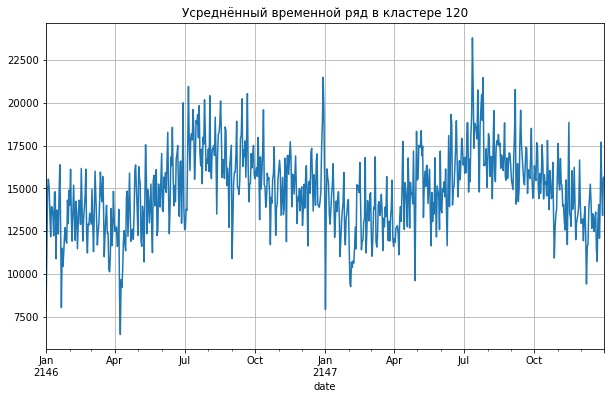

In [9]:
data['y'].plot()
plt.title('Усреднённый временной ряд в кластере 120')
plt.grid()
plt.show()

Когда данные подготовлены, переходим к построению модели. Для построения пуассоновской регрессии используем библиотеку `scikit-learn`. Для построения `SARIMA` используется авторская библиотека
<a href="https://github.com/tsyploff/tsyplov_stats/tree/master/tsyplov_stats">tsyplov_stats</a>, написанная в рамках учебного проекта. 

In [10]:
from sklearn.linear_model import PoissonRegressor
from sklearn.base import BaseEstimator

In [11]:
from tsyplov_stats.sarima_model import SARIMA
from tsyplov_stats.validation import *

In [12]:
class SARIMAX(BaseEstimator):
    
    def __init__(self, alpha=0, max_iter=512, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)):
        '''
        alpha – poisson regression regularization parameter
        max_iter – max iteration for poisson regressor learning
        '''
        self.poiss = PoissonRegressor(alpha=alpha, max_iter=max_iter, tol=1e-6)
        self.sarima = SARIMA(order=order, seasonal_order=seasonal_order)
    
    def fit(self, X, y):
        self.last_features = X[-1:]
        self.poiss.fit(X, y)
        self.sarima.fit(y - self.poiss.predict(X))
        return self
        
    def predict(self, X='None', h=1):
        '''
        h – steps quantity to predict 
        '''
        return self.sarima.predict(h) + self.poiss.predict(X)

Честно говоря, настройки для `SARIMA` взяты с потолка, хотя надо было бы построить автокоррелограмму и т. п. Будем считать, что имеет место недельный сезонный лаг. Построим модель

In [13]:
reg = SARIMAX(order=(5, 0, 5), seasonal_order=(2, 0, 2, 7)).fit(data.drop(columns=['y']).values, data['y'].values)

Посмотрим на предсказанные значения и построим прогноз на неделю вперёд. Дополнительные признаки $x_i$ будем считать известными. 

In [14]:
fitted_values = np.hstack((np.zeros(28), reg.sarima.fitted_values)) 
fitted_values += reg.poiss.predict(data.drop(columns=['y']).values) 

In [15]:
forecast_dates = pd.date_range(start=data.index[-1], periods=8)
forecast = reg.predict(data.drop(columns=['y']).values[-7:], h=7)
forecast = np.hstack((fitted_values[-1:], forecast))

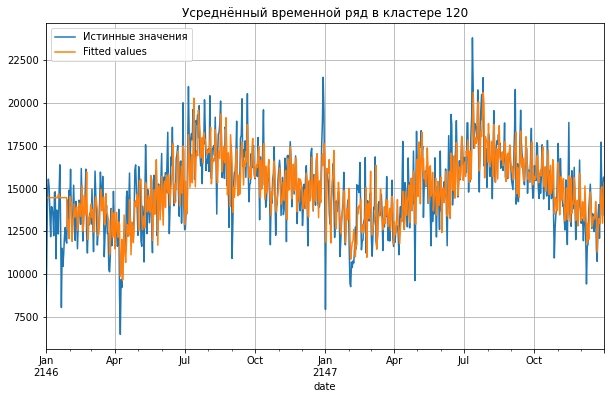

In [16]:
data['y'].plot(label='Истинные значения')
plt.title('Усреднённый временной ряд в кластере 120')
plt.plot(data.index, fitted_values, label='Fitted values')
plt.legend()
plt.grid()
plt.show()

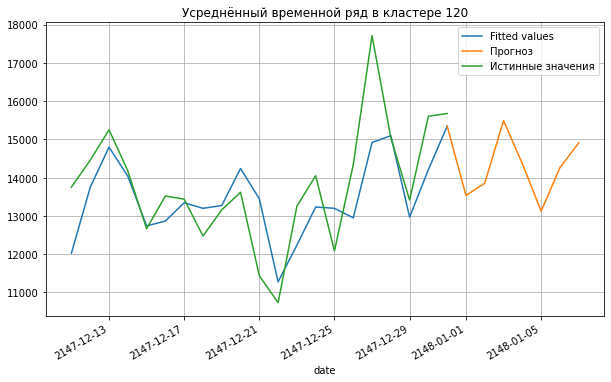

In [17]:
plt.plot(data.index[-21:], fitted_values[-21:], label='Fitted values')
plt.plot(forecast_dates, forecast, label='Прогноз')
data['y'].iloc[-21:].plot(label='Истинные значения')
plt.title('Усреднённый временной ряд в кластере 120')
plt.legend()
plt.grid()
plt.show()

Проверим результаты на кросс-валидации

In [18]:
model = SARIMA(order=(5, 0, 5), seasonal_order=(2, 0, 2, 7))

In [19]:
ts, n, k = reg.sarima.series.copy(), 146, 4
results = cross_val_score(model, mean_absolute_error, time_series_split(ts, n, k))

In [20]:
print('MAE на кросс-валидации: {:.2f}'.format(results.mean()))

MAE на кросс-валидации: 2085.91


У нас есть прогноз для усреднённого временного ряда в кластере. Чтобы получить прогноз для отдельных магазинов, используем мультипликатор. 

In [21]:
multiplier = data[['y']].copy()
multiplier.index.name = None
multiplier['date'] = data.index.to_numpy()
for shop_id in shop_ids:
    tmp = data1[data1['shop_id'] == shop_id][['date', 'y']].rename(columns={'y': 'y' + str(shop_id)})
    multiplier = multiplier.merge(tmp, how='inner', on='date')

In [22]:
M = multiplier.drop(columns=['date']).values
M = pd.DataFrame({'multiplier' : np.mean(M[:, 1:] / M[:, :1], axis=0)}, index=shop_ids)
M

,multiplier
shop_id,
0,1.076145
1,0.834703
6,1.065512
40,1.146248
43,1.123858
45,0.753535


Домножаем прогноз для усреднённого ряда на мультипликаторы

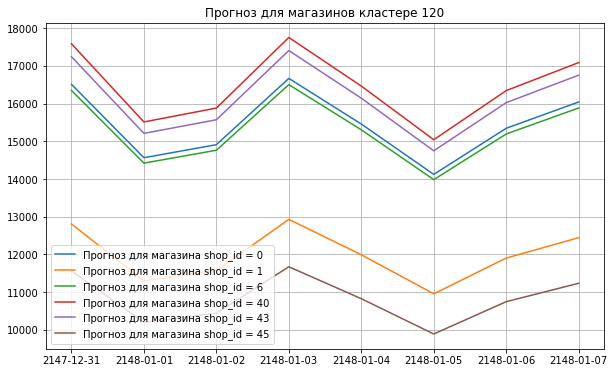

In [23]:
for shop_id in shop_ids:
    plt.plot(forecast_dates, M.loc[shop_id]['multiplier']*forecast, label='Прогноз для магазина shop_id = ' + str(shop_id))

plt.title('Прогноз для магазинов кластере 120')
plt.legend()
plt.grid()
plt.show()

Получаем прогноз для каждого магазина в кластере